<a href="https://colab.research.google.com/github/vinsensiuskurniaputra/mechineLearningParctice/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification
1. Binary Classification = one think or other (cat vs dog)
2. Multiclass Classification = more than one think or another (cat vs dog vs chicken)

###1. Create a Data

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

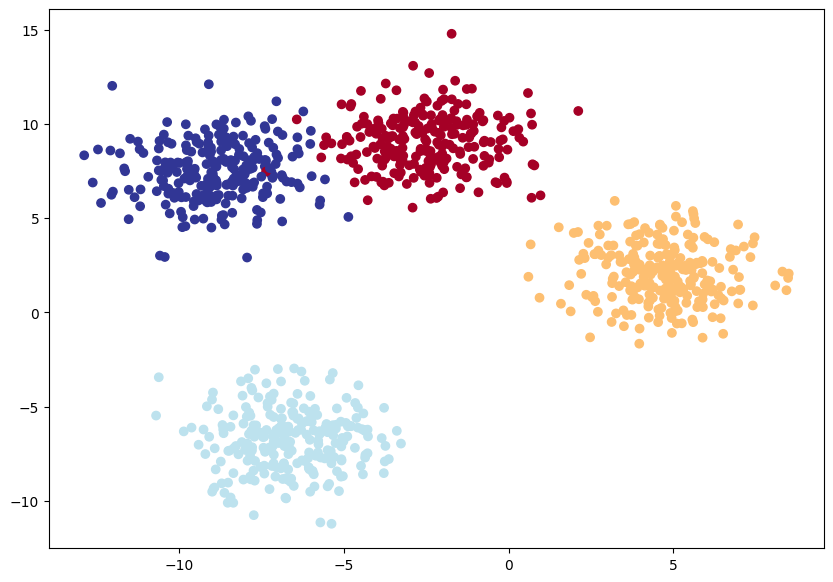

In [31]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create Multi-class data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape


### 2. Building Multiclass clasification model

In [32]:
# Create device code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
from torch import nn
# Build Model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initial Model
    Args:
      input_features (int): Number of input features
      output_features (int): Number of output features
      hidden_units (int, optional): Number of hidden units. Defaults to 8.
    """
    super().__init__()
    self.linear_layer_stack = torch.nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance model
model_1 = BlobModel(input_features=2, output_features=4).to(device)
model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 3. Create loss function and optimazer

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### 4. Getting Prediction

In [35]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test.to(device))

### 5. Create a training loop and testing loop

In [36]:
manual_seed = 42
torch.manual_seed(manual_seed)
torch.cuda.manual_seed(manual_seed)

epopch = 100


X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epopch):
  model_1.train()
  y_logits = model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = (y_pred == y_blob_train).sum()/len(y_blob_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = (test_pred == y_blob_test).sum()/len(y_blob_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.1588 | Acc: 0.40 | Test Loss: 1.0755 | Test Acc: 0.48
Epoch: 10 | Loss: 0.6448 | Acc: 0.97 | Test Loss: 0.6607 | Test Acc: 0.97
Epoch: 20 | Loss: 0.4254 | Acc: 0.98 | Test Loss: 0.4307 | Test Acc: 1.00
Epoch: 30 | Loss: 0.2529 | Acc: 0.99 | Test Loss: 0.2451 | Test Acc: 1.00
Epoch: 40 | Loss: 0.1123 | Acc: 0.99 | Test Loss: 0.1023 | Test Acc: 1.00
Epoch: 50 | Loss: 0.0663 | Acc: 0.99 | Test Loss: 0.0585 | Test Acc: 1.00
Epoch: 60 | Loss: 0.0507 | Acc: 0.99 | Test Loss: 0.0429 | Test Acc: 1.00
Epoch: 70 | Loss: 0.0430 | Acc: 0.99 | Test Loss: 0.0349 | Test Acc: 1.00
Epoch: 80 | Loss: 0.0384 | Acc: 0.99 | Test Loss: 0.0299 | Test Acc: 1.00
Epoch: 90 | Loss: 0.0352 | Acc: 0.99 | Test Loss: 0.0266 | Test Acc: 1.00


In [37]:
test_logits.shape, y_blob_test.shape

(torch.Size([200, 4]), torch.Size([200]))

### 6. Make Prediction

In [38]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test)

In [41]:
# Go from logits to prediction probality
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10], y_blob_test[:10]

(tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
         [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
         [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
         [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
         [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
         [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
         [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
         [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
         [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
         [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

In [43]:
# Go from pred prob to pred label
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))